## Data import

In [198]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

AA_df = pd.read_csv("Data S1.csv", encoding="utf-8") 

# Define amino acid list once at the top
amino_acids = [
    "Tau", "Lys", "Asn", "Arg", "Met", "Gln", "Orn", "Phe", 
    "Leu", "Thr", "Gly", "Ser", "Tyr", "Ala", "Val", "Trp", "Ile+Glu"
]

In [199]:
AA_df = AA_df.dropna(subset=['pTNM stage'] + amino_acids)

In [200]:
AA_df

,Sample,Tau,Lys,Asn,Arg,Met,Gln,Orn,Phe,Leu,...,pN,pM,Number of positive lymph nodes,Number of harvested lymph nodes,Tumor size (cm),Histologic grade,Lymphovascular invasion,Perineural invasion,Last follow-up date,Recurrence
0,Patient-144,97.411,103.533,31.423,0.000,15.808,197.833,31.726,37.455,93.192,...,0.0,0.0,0.0,46.0,1.7,Well-differentiated,No invasion,No invasion,NaN,NaN
1,Patient-145,73.993,70.206,21.191,0.000,0.000,367.578,0.000,27.415,238.829,...,0.0,0.0,0.0,15.0,3.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
2,Patient-146,65.505,90.469,0.000,0.000,0.000,181.527,0.000,16.784,89.368,...,0.0,0.0,0.0,12.0,0.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
3,Patient-147,42.170,77.167,0.000,41.121,0.000,192.521,13.172,21.775,30.512,...,0.0,0.0,0.0,57.0,8.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
4,Patient-148,128.726,139.303,39.297,54.231,48.967,356.260,63.024,34.642,133.589,...,1.0,0.0,1.0,46.0,9.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Patient-024,124.315,172.431,0.000,58.213,28.906,367.515,103.372,77.159,144.639,...,0.0,0.0,0.0,30.0,5.7,Moderately differentiated,Lymphovascular invasion,No invasion,2022-05-22,Yes
148,Patient-025,152.506,131.335,43.920,29.851,27.922,415.112,118.936,64.782,120.672,...,NaN,NaN,NaN,NaN,NaN,Mucinous,NaN,NaN,NaN,NaN
149,Patient-026,119.279,207.649,90.775,62.947,51.336,678.529,93.942,64.417,107.694,...,2.0,1.0,18.0,18.0,12.0,Poorly differentiated,Lymphovascular invasion,No invasion,2019-05-23,Yes
150,Patient-027,0.000,53.241,0.000,16.388,0.000,137.560,11.158,14.486,21.526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-08,Yes


## Data Pre-processing

In [201]:
## Data Pre-processing
AA_df['Total'] = AA_df[amino_acids].sum(axis=1)
for aa in amino_acids:
    AA_df[f'{aa}_ratio'] = AA_df[aa] / AA_df['Total']
    AA_df[f'log1p_{aa}_ratio'] = np.log1p(AA_df[f'{aa}_ratio'])
scaler = StandardScaler()
zscore_columns = [f'zscore_log1p_{aa}_ratio' for aa in amino_acids]
AA_df[zscore_columns] = scaler.fit_transform(AA_df[[f'log1p_{aa}_ratio' for aa in amino_acids]])


## Essential vs Conditionally vs Non-essential

In [202]:
# first Define the amino acid groups
essential = ['Lys', 'Met', 'Phe', 'Leu', 'Thr', 'Val', 'Trp']
conditional = ['Arg', 'Gln', 'Gly', 'Tyr']
nonessential = ['Asn', 'Ala','Tau', 'Ser','Orn']

In [203]:
# Function to compute total ratios of each amino acid group per sample
def calculate_group_ratios(df, ea, ca, na):
    df['EA_sum'] = df[[f'{aa}_ratio' for aa in ea]].sum(axis=1)
    df['CA_sum'] = df[[f'{aa}_ratio' for aa in ca]].sum(axis=1)
    df['NA_sum'] = df[[f'{aa}_ratio' for aa in na]].sum(axis=1)
    return df

# Apply the ratio calculation to the input DataFrame
AA_df = calculate_group_ratios(AA_df, essential, conditional, nonessential)

# Map numeric stage values to categorical stage labels
AA_df['Stage_Group'] = AA_df['pTNM stage'].map({1: 'Stage I', 2: 'Stage II', 3: 'Stage III', 4: 'Stage IV'})


Plotting ratios across Stages I, II, III, IV...


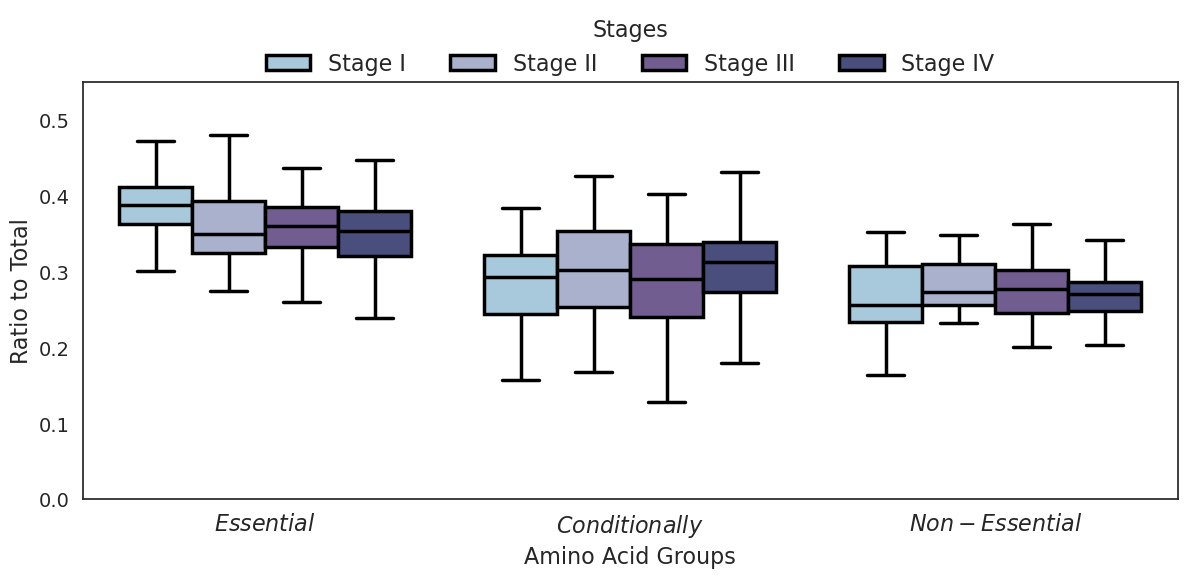

In [204]:
# Function to generate boxplots for group-wise amino acid ratios across stages
def plot_combined_ratios_boxplot(data, group_ratios, stage_column, title_suffix, y_lim=None):
    plt.figure(figsize=(12, 6))

    # Predefined color scheme for cancer stages
    color = {
        "Stage I": '#9ECCE4', 
        "Stage II": '#A3ADD3', 
        "Stage III": '#715499', 
        "Stage IV": '#404884'
    }

    # Convert data to long format for seaborn boxplot
    melted_data = data.melt(
        id_vars=[stage_column], 
        value_vars=group_ratios, 
        var_name='Ratio_Type', 
        value_name='Ratio_Value'
    )

    # Draw boxplot with consistent styling and custom color palette
    sns.boxplot(
        x='Ratio_Type',
        y='Ratio_Value',
        hue=stage_column,
        data=melted_data,
        palette=[color[stage] for stage in data[stage_column].unique()],
        linewidth=2.5,
        dodge=True,
        showfliers=False,
        boxprops=dict(edgecolor='black', linewidth=2.5),
        whiskerprops=dict(color='black', linewidth=2.5),
        capprops=dict(color='black', linewidth=2.5),
        medianprops=dict(color='black', linewidth=2.5)
    )

    # Axis labeling
    plt.ylabel('Ratio to Total', fontsize=16)
    plt.xlabel('Amino Acid Groups', fontsize=16)
    plt.xticks(
        ticks=[0, 1, 2],
        labels=[r'$\mathit{Essential}$', r'$\mathit{Conditionally}$', r'$\mathit{Non-Essential}$'],
        fontsize=16,
        rotation=0,
        ha='center'
    )
    plt.yticks(fontsize=14)

    # Optional y-axis limit
    if y_lim is not None:
        plt.ylim(y_lim)

    # Legend settings
    plt.legend(
        title="Stages",
        loc='upper center',
        bbox_to_anchor=(0.5, 1.2),
        ncol=4,
        frameon=False,
        fontsize=16,
        title_fontsize=16
    )

    plt.tight_layout()
    plt.show()

# Plot Execution 
print("\nPlotting ratios across Stages I, II, III, IV...")
plot_combined_ratios_boxplot(
    AA_df, 
    ['EA_sum', 'CA_sum', 'NA_sum'], 
    'Stage_Group', 
    title_suffix='I-IV', 
    y_lim=(0.0, 0.55)
)

In [205]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests

# List of target variables for statistical testing
ratios = ['EA_sum', 'CA_sum', 'NA_sum']

# Containers to store test results
kruskal_results = []
dunn_results = []

for ratio in ratios:
    # Perform Kruskal-Wallis test across pTNM stages
    groups = [group[ratio].values for name, group in AA_df.groupby('pTNM stage')]
    stat, p_value = kruskal(*groups)
    kruskal_results.append([ratio, stat, p_value])

    # If Kruskal-Wallis is marginally significant, proceed to Dunn’s test
    if p_value < 0.07:
        dunn_test = sp.posthoc_dunn(
            AA_df, 
            val_col=ratio, 
            group_col='pTNM stage', 
            p_adjust=None  # Raw p-values for now
        )

        # Collect all pairwise comparisons (avoid duplicates)
        for stage1 in dunn_test.index:
            for stage2 in dunn_test.columns:
                if stage1 < stage2:
                    dunn_results.append([
                        ratio, stage1, stage2, dunn_test.loc[stage1, stage2]
                    ])

# Compile Kruskal-Wallis test results into a DataFrame
kruskal_df = pd.DataFrame(kruskal_results, columns=['Ratio', 'H-statistic', 'p-value'])
print("\nKruskal-Wallis Test Results:")
print(kruskal_df.to_string(index=False))

# Perform FDR-BH correction for Dunn’s test if applicable
if dunn_results:
    dunn_df = pd.DataFrame(dunn_results, columns=['Ratio', 'Stage 1', 'Stage 2', 'Raw P-value'])
    dunn_df['Adjusted P-value (FDR)'] = multipletests(
        dunn_df['Raw P-value'], method='fdr_bh'
    )[1]

    print("\nDunn’s Test Results (FDR-BH Adjusted):")
    print(dunn_df.to_string(index=False))



Kruskal-Wallis Test Results:
 Ratio  H-statistic  p-value
EA_sum     9.477354 0.023573
CA_sum     3.889396 0.273658
NA_sum     4.388532 0.222451

Dunn’s Test Results (FDR-BH Adjusted):
 Ratio  Stage 1  Stage 2  Raw P-value  Adjusted P-value (FDR)
EA_sum      1.0      2.0     0.025365                0.056403
EA_sum      1.0      3.0     0.028202                0.056403
EA_sum      1.0      4.0     0.002192                0.013154
EA_sum      2.0      3.0     0.902424                0.902424
EA_sum      2.0      4.0     0.562258                0.674710
EA_sum      3.0      4.0     0.449909                0.674710


## Correlation

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define list of essential amino acids (EA) for ratio columns
aa_cols = [f"{aa}_ratio" for aa in ['Lys', 'Met', 'Phe', 'Leu', 'Thr', 'Val', 'Trp']]

# Include EA_sum for correlation analysis
cols = aa_cols + ['EA_sum']

# Compute stage-wise mean values for each amino acid and EA_sum
df_stage = AA_df.groupby('pTNM stage')[cols].mean().reset_index()

# Calculate Pearson correlation between EA_sum and each individual amino acid
correlation_results = []
for aa in aa_cols:
    r_value, p_value = pearsonr(df_stage['EA_sum'], df_stage[aa])
    correlation_results.append((
        aa,
        round(r_value, 3),                      # Rounded Pearson R
        "{:.3e}".format(p_value)                # Scientific notation for p-value
    ))

# Convert results to a DataFrame
corr_df = pd.DataFrame(correlation_results, columns=['Amino_Acid', 'Pearson_R', 'P-value'])

# Sort by p-value for easier interpretation
corr_df = corr_df.sort_values(by='P-value')

# Display the results
print("Pearson correlation between EA_sum and each essential amino acid")
print(corr_df)


Pearson correlation between EA_sum and each essential amino acid
  Amino_Acid  Pearson_R    P-value
5  Val_ratio      0.990  1.047e-02
2  Phe_ratio     -0.835  1.652e-01
4  Thr_ratio     -0.716  2.844e-01
0  Lys_ratio      0.656  3.438e-01
6  Trp_ratio      0.964  3.575e-02
3  Leu_ratio      0.991  8.947e-03
1  Met_ratio      0.079  9.208e-01


In [158]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests

# List of target variables for statistical testing
ratios = ['EA_sum', 'CA_sum', 'NA_sum']

# Containers to store test results
kruskal_results = []
dunn_results = []

for ratio in ratios:
    # Perform Kruskal-Wallis test across pTNM stages
    groups = [group[ratio].values for name, group in AA_df.groupby('pTNM stage')]
    stat, p_value = kruskal(*groups)
    kruskal_results.append([ratio, stat, p_value])

    # If Kruskal-Wallis is marginally significant, proceed to Dunn’s test
    if p_value < 0.07:
        dunn_test = sp.posthoc_dunn(
            AA_df, 
            val_col=ratio, 
            group_col='pTNM stage', 
            p_adjust=None  # Raw p-values for now
        )

        # Collect all pairwise comparisons (avoid duplicates)
        for stage1 in dunn_test.index:
            for stage2 in dunn_test.columns:
                if stage1 < stage2:
                    dunn_results.append([
                        ratio, stage1, stage2, dunn_test.loc[stage1, stage2]
                    ])

# Compile Kruskal-Wallis test results into a DataFrame
kruskal_df = pd.DataFrame(kruskal_results, columns=['Ratio', 'H-statistic', 'p-value'])
print("\nKruskal-Wallis Test Results:")
print(kruskal_df.to_string(index=False))

# Perform FDR-BH correction for Dunn’s test if applicable
if dunn_results:
    dunn_df = pd.DataFrame(dunn_results, columns=['Ratio', 'Stage 1', 'Stage 2', 'Raw P-value'])
    dunn_df['Adjusted P-value (FDR)'] = multipletests(
        dunn_df['Raw P-value'], method='fdr_bh'
    )[1]

    print("\nDunn’s Test Results (FDR-BH Adjusted):")
    print(dunn_df.to_string(index=False))



Kruskal-Wallis Test Results:
 Ratio  H-statistic  p-value
EA_sum     9.477354 0.023573
CA_sum     3.889396 0.273658
NA_sum     4.388532 0.222451

Dunn’s Test Results (FDR-BH Adjusted):
 Ratio  Stage 1  Stage 2  Raw P-value  Adjusted P-value (FDR)
EA_sum      1.0      2.0     0.025365                0.056403
EA_sum      1.0      3.0     0.028202                0.056403
EA_sum      1.0      4.0     0.002192                0.013154
EA_sum      2.0      3.0     0.902424                0.902424
EA_sum      2.0      4.0     0.562258                0.674710
EA_sum      3.0      4.0     0.449909                0.674710


/tmp/ipykernel_208508/1719931905.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


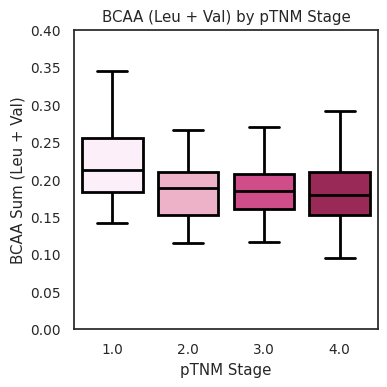

Kruskal-Wallis H-statistic: 7.969
p-value: 4.666e-02


In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Calculate BCAA sum (Leucine + Valine)
AA_df['BCAA_sum'] = AA_df['Leu_ratio'] + AA_df['Val_ratio']

# Define custom color palette for pTNM stages
custom_palette = ["#FFEDFA", "#F7A8C4", "#E53888", "#AC1754"]  # Stage I ~ IV

# Draw boxplot of BCAA sum by pTNM stage
plt.figure(figsize=(4, 4))
sns.boxplot(
    x='pTNM stage', 
    y='BCAA_sum', 
    data=AA_df,
    palette=custom_palette,
    showfliers=False,
    boxprops=dict(edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    medianprops=dict(color='black', linewidth=2)
)

plt.ylim(0, 0.4)
plt.title("BCAA (Leu + Val) by pTNM Stage")
plt.xlabel("pTNM Stage")
plt.ylabel("BCAA Sum (Leu + Val)")
plt.tight_layout()
# plt.savefig("BCAA_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Perform Kruskal-Wallis test across pTNM stages
groups = [group['BCAA_sum'].values for name, group in AA_df.groupby('pTNM stage')]
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis H-statistic:", round(stat, 3))
print("p-value:", "{:.3e}".format(p_value))


In [160]:
import scikit_posthocs as sp
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# Kruskal-Wallis 검정
stat, p_value = kruskal(*[AA_df[AA_df['pTNM stage'] == stage]['BCAA_sum'].values for stage in AA_df['pTNM stage'].unique()])
print(f"Kruskal-Wallis Test: p-value = {p_value:.4f}")

# 사후분석 (Dunn’s Test + FDR-BH 보정)
if p_value < 0.05:
    dunn_test = sp.posthoc_dunn(AA_df, val_col='BCAA_sum', group_col='pTNM stage', p_adjust='fdr_bh')
    print("\nDunn’s Test Results (FDR-BH Adjusted):")
    print(dunn_test)


Kruskal-Wallis Test: p-value = 0.0467

Dunn’s Test Results (FDR-BH Adjusted):
          1.0       2.0       3.0       4.0
1.0  1.000000  0.066125  0.066125  0.033445
2.0  0.066125  1.000000  0.998959  0.838402
3.0  0.066125  0.998959  1.000000  0.838402
4.0  0.033445  0.838402  0.838402  1.000000


/tmp/ipykernel_208508/4285747241.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


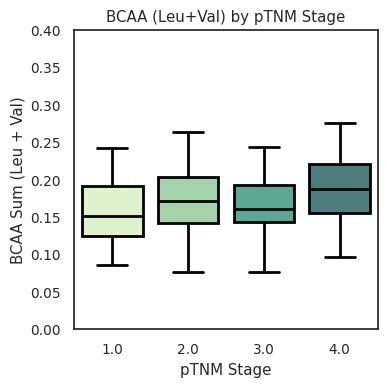

Kruskal-Wallis H-statistic: 7.932102194331264
p-value: 0.04743598977702717


In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# fpdf 데이터프레임에 'pTNM', 'Leu_ratio', 'Val_ratio' 컬럼이 있다고 가정
# BCAA_sum 변수 생성 (Leu_ratio + Val_ratio)
AA_df['GlySerThr_sum'] = AA_df['Gly_ratio'] + AA_df['Ser_ratio'] + AA_df['Thr_ratio'] 

# pTNM이 문자열로 "Stage I", "Stage II", ... 라면, 원하는 색상에 맞춰 팔레트와 순서 지정
custom_palette = ["#DEF9C4", "#9CDBA6", "#50B498", "#468585"]  # 예시 색상 (Stage I ~ IV)
# pTNM 그룹 순서 지정 (예: Stage I, Stage II, Stage III, Stage IV)
# 필요하다면 order=['Stage I','Stage II','Stage III','Stage IV'] 파라미터를 sns.boxplot()에 추가

plt.figure(figsize=(4, 4))
sns.boxplot(
    x='pTNM stage', 
    y='GlySerThr_sum', 
    data=AA_df,
    palette=custom_palette,        # 사용자 지정 색상
    showfliers=False,              # outlier 표시 제거
    boxprops=dict(edgecolor='black', linewidth=2),   # 박스 테두리
    whiskerprops=dict(color='black', linewidth=2),   # 수염
    capprops=dict(color='black', linewidth=2),       # 수염 끝 캡
    medianprops=dict(color='black', linewidth=2)     # 중앙선
)

# y축 범위를 사용자 지정 (예시: 0 ~ 100)
plt.ylim(0, 0.4)

plt.title("BCAA (Leu+Val) by pTNM Stage")
plt.xlabel("pTNM Stage")
plt.ylabel("BCAA Sum (Leu + Val)")
plt.tight_layout()
#plt.savefig("GlySerThr_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Kruskal-Wallis 검정 수행
groups = [group['GlySerThr_sum'].values for name, group in AA_df.groupby('pTNM stage')]
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis H-statistic:", stat)
print("p-value:", p_value)


In [162]:
import scikit_posthocs as sp
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# Kruskal-Wallis 검정
stat, p_value = kruskal(*[AA_df[AA_df['pTNM stage'] == stage]['GlySerThr_sum'].values for stage in AA_df['pTNM stage'].unique()])
print(f"Kruskal-Wallis Test: p-value = {p_value:.4f}")

# 사후분석 (Dunn’s Test + FDR-BH 보정)
if p_value < 0.05: 
    dunn_test = sp.posthoc_dunn(AA_df, val_col='GlySerThr_sum', group_col='pTNM stage', p_adjust='fdr_bh')
    print("\nDunn’s Test Results (FDR-BH Adjusted):")
    print(dunn_test)


Kruskal-Wallis Test: p-value = 0.0474

Dunn’s Test Results (FDR-BH Adjusted):
          1.0       2.0       3.0       4.0
1.0  1.000000  0.377860  0.632146  0.092369
2.0  0.377860  1.000000  0.530217  0.377860
3.0  0.632146  0.530217  1.000000  0.092369
4.0  0.092369  0.377860  0.092369  1.000000


## Correlation analysis

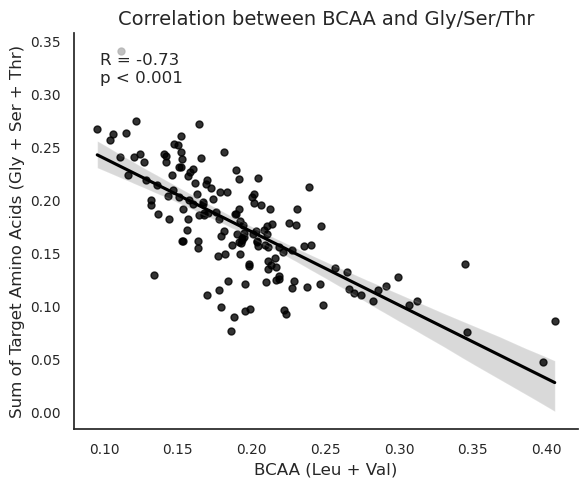


### Correlation Results ###
  Correlation Type  Correlation Coefficient       P-value
0         Spearman                -0.731532  9.902381e-27


In [169]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Spearman correlation between BCAA and Gly+Ser+Thr
r_value, p_value = spearmanr(AA_df['BCAA_sum'], AA_df['GlySerThr_sum'])
p_text = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

# Scatter plot with regression line
plt.figure(figsize=(6, 5))
sns.regplot(
    x=AA_df['BCAA_sum'], 
    y=AA_df['GlySerThr_sum'], 
    scatter_kws={'s': 25, 'color': 'black', 'alpha': 0.8},
    line_kws={'color': 'black'},
    ci=95
)

# Annotate R and p-value
plt.text(
    0.05, 0.95, f"R = {r_value:.2f}\n{p_text}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

# Axis labels and title
plt.xlabel("BCAA (Leu + Val)", fontsize=12)
plt.ylabel("Sum of Target Amino Acids (Gly + Ser + Thr)", fontsize=12)
plt.title("Correlation between BCAA and Gly/Ser/Thr", fontsize=14)

# Clean plot style
sns.despine()
plt.tight_layout()
plt.savefig("BCAA_GlySerThr_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Save and print correlation results
correlation_results = pd.DataFrame({
    "Correlation Type": ["Spearman"],
    "Correlation Coefficient": [r_value],
    "P-value": [p_value]
})

print("\n### Correlation Results ###")
print(correlation_results)


## Kaplan-Meier curve

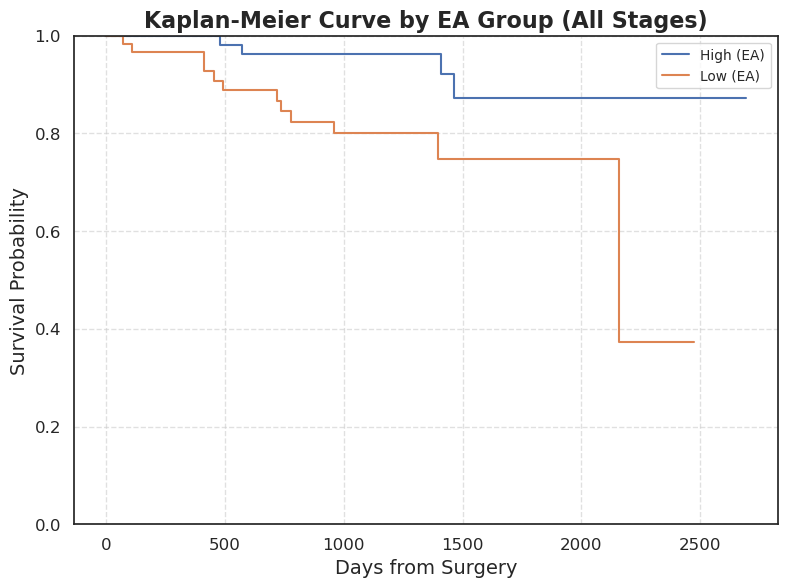

EA - Log-rank test p-value (All Stages): 0.02003877219524366


In [207]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Dichotomize EA_sum based on median
median_ea = AA_df['EA_sum'].median()
AA_df['EA_Group'] = np.where(AA_df['EA_sum'] >= median_ea, 'High', 'Low')

# Convert date columns
AA_df['SurgeryDate'] = pd.to_datetime(AA_df['Surgery date'], errors='coerce')
AA_df['DeathDate'] = pd.to_datetime(AA_df['Death date'], errors='coerce')
AA_df['LastFollowupDate'] = pd.to_datetime(AA_df['Last follow-up date'], errors='coerce')

# Define event status: 1 = death, 0 = censored
AA_df['Event'] = AA_df['DeathDate'].notnull().astype(int)

# Calculate survival time (in days)
AA_df['SurvivalDays'] = np.where(
    AA_df['Event'] == 1,
    (AA_df['DeathDate'] - AA_df['SurgeryDate']).dt.days,
    (AA_df['LastFollowupDate'] - AA_df['SurgeryDate']).dt.days
)

# Remove invalid or missing data
data = AA_df.dropna(subset=['SurvivalDays'])
data = data[data['SurvivalDays'] >= 0]

# Kaplan-Meier estimation by EA group
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

high_group = data[data['EA_Group'] == 'High']
low_group = data[data['EA_Group'] == 'Low']

kmf_high.fit(high_group['SurvivalDays'], event_observed=high_group['Event'], label='High (EA)')
kmf_low.fit(low_group['SurvivalDays'], event_observed=low_group['Event'], label='Low (EA)')

# Plot KM curves (without confidence intervals)
plt.figure(figsize=(8, 6))
kmf_high.plot_survival_function(ci_show=False)
kmf_low.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Curve by EA Group (All Stages)", fontsize=16, fontweight='bold')
plt.xlabel("Days from Surgery", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
#plt.savefig("KM_Curve_EA.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Log-rank test
results = logrank_test(
    high_group['SurvivalDays'], low_group['SurvivalDays'],
    event_observed_A=high_group['Event'], event_observed_B=low_group['Event']
)
print("EA - Log-rank test p-value (All Stages):", results.p_value)
